 # Statistical evaluation of chord-prediction performances

In [1]:
import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az

from bambi import Prior

/Users/harasim/Documents/repos/python/jazz-chord-melody/env/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


 ## Chord-level descriptive statistics

In [2]:
rawdata = pd.read_csv('../output_data_array.csv')
rawdata['acc_no_mel'] = rawdata.target == rawdata.prediction_no_melody
rawdata['acc_with_mel'] = rawdata.target == rawdata.prediction_with_melody
rawdata.head()

,Unnamed: 0,melid,bar,beat,target,prediction_no_melody,prediction_with_melody,notes,fold,acc_no_mel,acc_with_mel
0,0,1,1,1,Bb6,D7,G7,"58,58",6,False,False
1,1,1,1,3,G7,C7,G7,NaN,6,False,True
2,2,1,2,1,C-7,C7,C-7,NaN,6,False,True
3,3,1,2,3,F7,F7,F7,NaN,6,True,True
4,4,1,3,1,Bb,Bbmaj7,Bbmaj7,NaN,6,False,False


In [3]:
print("chord-level accuracies:")
rawdata.acc_no_mel.mean(), rawdata.acc_with_mel.mean()

chord-level accuracies:


(0.44953201804592285, 0.4737054743788297)

In [4]:
print("chord-level standard errors:")
rawdata.acc_no_mel.sem(), rawdata.acc_with_mel.sem()

chord-level standard errors:


(0.002886428544356293, 0.0028972307919496857)

In [5]:
print("chord-level accuracy difference:")
rawdata.acc_with_mel.mean() - rawdata.acc_no_mel.mean()

chord-level accuracy difference:


0.02417345633290685

 ## Tune-level descriptive statistics

In [6]:
widedata = rawdata.groupby('melid').mean().reset_index()\
  [['melid', 'fold', 'acc_no_mel', 'acc_with_mel']]
widedata.head()

,melid,fold,acc_no_mel,acc_with_mel
0,1,6.0,0.761194,0.736318
1,2,1.0,0.706422,0.779817
2,3,9.0,0.403509,0.421053
3,4,10.0,0.298077,0.278846
4,5,2.0,0.270833,0.270833


In [7]:
print("tune-level accuracies:")
widedata.acc_no_mel.mean(), widedata.acc_with_mel.mean()

tune-level accuracies:


(0.4354678585318363, 0.45881870490459903)

In [8]:
print("tune-level accuracy difference:")
widedata.acc_with_mel.mean() - widedata.acc_no_mel.mean()

tune-level accuracy difference:


0.023350846372762746

In [9]:
print("tune-level standard errors:")
widedata.acc_no_mel.sem(), widedata.acc_with_mel.sem()

tune-level standard errors:


(0.010856834365224024, 0.012022209458631685)

In [10]:
print("average accuracy increase for tunes with prediction improvement")
better = widedata[widedata.acc_no_mel < widedata.acc_with_mel]
(better.acc_with_mel - better.acc_no_mel).mean()

average accuracy increase for tunes with prediction improvement


0.11940568124575972

In [11]:
print("average accuracy decrease for tunes without prediction improvement")
worse = widedata[widedata.acc_no_mel > widedata.acc_with_mel]
(worse.acc_no_mel - worse.acc_with_mel).mean()

average accuracy decrease for tunes without prediction improvement


0.09475156955716542

In [12]:
print('portion of tunes for which melody increased accuracy:')
((widedata.acc_with_mel - widedata.acc_no_mel) > 0).mean()

portion of tunes for which melody increased accuracy:


0.496551724137931

 ## Evidence quantification for hypothesis that melody improves accuracy predictions

In [13]:
data = widedata.melt(id_vars=['melid', 'fold'], value_vars=['acc_no_mel', 'acc_with_mel'], var_name='model', value_name='accuracy')
data.rename(columns={'melid': 'tune'}, inplace=True)
data.head()

,tune,fold,model,accuracy
0,1,6.0,acc_no_mel,0.761194
1,2,1.0,acc_no_mel,0.706422
2,3,9.0,acc_no_mel,0.403509
3,4,10.0,acc_no_mel,0.298077
4,5,2.0,acc_no_mel,0.270833


In [14]:
priors = {
  'model': Prior("Normal", mu=0, sigma=0.2),
  '1|tune': Prior("Normal", mu=0, sigma=Prior("HalfNormal", sigma=0.4)),
  '1|fold': Prior("Normal", mu=0, sigma=Prior("HalfNormal", sigma=0.4)),
  'model|fold': Prior("Normal", mu=0, sigma=Prior("HalfNormal", sigma=0.2)),
}

model = bmb.Model(
  "accuracy ~ model + (1|tune) + (model|fold)", 
  data,
  priors=priors,
)

model

Formula: accuracy ~ model + (1|tune) + (model|fold)
Family name: Gaussian
Link: identity
Observations: 870
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.4471, sigma: 0.5973)
    model ~ Normal(mu: 0, sigma: 0.2)

  Group-level effects
    1|tune ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.4))
    1|fold ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.4))
    model|fold ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.2))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.2389)

In [15]:
results = model.fit(
  draws=10_000, 
  tune=2_000, 
  chains=10, 
  cores=1, 
  target_accept= 0.95, 
  random_seed=42,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (10 chains in 1 job)
NUTS: [accuracy_sigma, model|fold_offset, model|fold_sigma, 1|fold_offset, 1|fold_sigma, 1|tune_offset, 1|tune_sigma, model, Intercept]


Sampling 10 chains for 2_000 tune and 10_000 draw iterations (20_000 + 100_000 draws total) took 1095 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
There were 221 divergences after tuning. Increase `target_accept` or reparameterize.
There were 309 divergences after tuning. Increase `target_accept` or reparameterize.
There were 360 divergences after tuning. Increase `target_accept` or reparameterize.
There were 421 divergences after tuning. Increase `target_accept` or reparameterize.
There were 573 divergences after tuning. Increase `target_accept` or reparameterize.
There were 727 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smalle

In [16]:
# Key summary and diagnostic info on the model parameters
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.436,0.014,0.409,0.461,0.0,0.0,11425.0,19772.0,1.0
model[acc_with_mel],0.023,0.008,0.008,0.039,0.0,0.0,61661.0,55898.0,1.0
1|tune_sigma,0.219,0.008,0.204,0.235,0.0,0.0,13712.0,26151.0,1.0
1|tune[1],0.265,0.067,0.139,0.391,0.0,0.0,63836.0,54307.0,1.0
1|tune[2],0.265,0.067,0.140,0.392,0.0,0.0,59692.0,54171.0,1.0
...,...,...,...,...,...,...,...,...,...
"model|fold[acc_with_mel, 7.0]",-0.006,0.012,-0.031,0.015,0.0,0.0,59531.0,68422.0,1.0
"model|fold[acc_with_mel, 8.0]",0.005,0.012,-0.017,0.030,0.0,0.0,60974.0,59874.0,1.0
"model|fold[acc_with_mel, 9.0]",-0.011,0.014,-0.042,0.010,0.0,0.0,39846.0,64289.0,1.0
"model|fold[acc_with_mel, 10.0]",0.008,0.013,-0.013,0.035,0.0,0.0,52622.0,70692.0,1.0


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'model'}>,
        <AxesSubplot:title={'center':'model'}>],
       [<AxesSubplot:title={'center':'1|tune_sigma'}>,
        <AxesSubplot:title={'center':'1|tune_sigma'}>],
       [<AxesSubplot:title={'center':'1|tune'}>,
        <AxesSubplot:title={'center':'1|tune'}>],
       [<AxesSubplot:title={'center':'1|fold_sigma'}>,
        <AxesSubplot:title={'center':'1|fold_sigma'}>],
       [<AxesSubplot:title={'center':'1|fold'}>,
        <AxesSubplot:title={'center':'1|fold'}>],
       [<AxesSubplot:title={'center':'model|fold_sigma'}>,
        <AxesSubplot:title={'center':'model|fold_sigma'}>],
       [<AxesSubplot:title={'center':'model|fold'}>,
        <AxesSubplot:title={'center':'model|fold'}>],
       [<AxesSubplot:title={'center':'accuracy_sigma'}>,
        <AxesSubplot:title={'center':'accuracy_sigma'}>]], dtype=object)

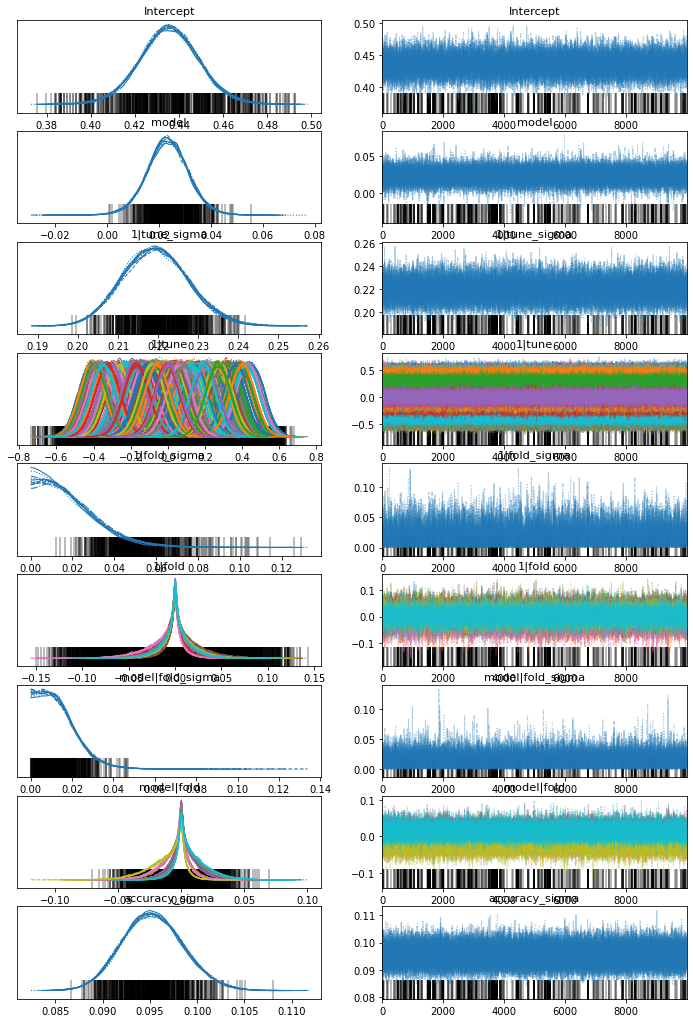

In [17]:
# Use ArviZ to plot the results
az.plot_trace(results)

In [18]:
# index mask for which samples melody improves accuracy prediction
idx = results.posterior['model'].values.flatten() > 0

print(f"total number of samples: {len(idx)}")
print(f"number of samples with positive melody coefficient: {idx.sum()}")
p = idx.mean()
print(f"proportion of positive melody coefficients: {p}")
print(f"odds of melody information improving prediction accuracy: {p/(1-p)}")

total number of samples: 100000
number of samples with positive melody coefficient: 99521
proportion of positive melody coefficients: 0.99521
odds of melody information improving prediction accuracy: 207.76826722338376


In [19]:
print("mean deviations of fold-specific models from overall model")
results.posterior['model|fold'].values.reshape((-1, 10)).mean(axis=0)

mean deviations of fold-specific models from overall model


array([ 0.00595648, -0.00420323, -0.00529702,  0.00272292,  0.00159362,
        0.00362299, -0.00560988,  0.00476899, -0.01118022,  0.00785838])